**首先到导入数据集，并对数据集进行初步处理并测试数据集的分类情况**

In [35]:
import numpy as np

def load_data():
    # 从文件导入数据
    datafile = r'D:\\firstweek\\housing.csv'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集,二者分别为0.8和0.2
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]
    
    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])
    
    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

接着编写函数实现向前结算功能，放入Network类中并测试其效果

In [ ]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
      
    def forward(self, x):
        # 计算输入数据 x 与权重矩阵 self.w 的点积，再加上偏置项 self.b
        z = np.dot(x, self.w) + self.b
        return z

In [71]:
# 此为测试代码
net = Network(13)
x1 = x[0]
y1 = y[0]
z = net.forward(x1)
print(z)

[-0.63182506]


接着再编写损失函数放入NetWork类中并测试效果

In [ ]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
    # 前向传播函数
    def forward(self, x):
        # 计算输入数据 x 与权重矩阵 self.w 的点积，再加上偏置项 self.b
        z = np.dot(x, self.w) + self.b
        return z
    # 损失函数
    def loss(self, z, y):
        # 计算预测值 z 与真实值 y 的误差
        error = z - y
        # 计算误差的平方
        cost = error * error
        # 对误差平方取平均值，得到均方误差
        cost = np.mean(cost)
        # 返回均方误差作为损失值
        return cost

In [82]:
# 下方为测试代码
net = Network(13)
x1 = x[0:3]
y1 = y[0:3]
z = net.forward(x1)
print('predict: ', z)
loss = net.loss(z, y1)
print('loss:', loss)

predict:  [[-0.63182506]
 [-0.55793096]
 [-1.00062009]]
loss: 0.7229825055441156


接下来以w5,w9为例实现梯度下降，首先画出图像L（w5，w9)即在3维空间中画出了损失函数随参数变化的曲面图

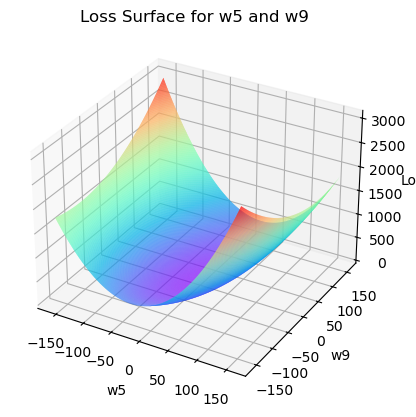

In [78]:
# 创建一个具有13个权重的神经网络实例
net = Network(13)

# 用于存储损失值的列表
losses = []

#只画出参数w5和w9在区间[-160, 160]的曲线部分，以及包含损失函数的极值
w5 = np.arange(-160.0, 160.0, 1.0)
w9 = np.arange(-160.0, 160.0, 1.0)

# 初始化一个二维数组，用于存储每个 w5 和 w9 组合对应的损失值
losses = np.zeros([len(w5), len(w9)])

# 遍历w5和w9的所有组合
for i in range(len(w5)):
    for j in range(len(w9)):
        # 设置网络中第 5 和第 9 个权重分别为当前的 w5[i] 和 w9[j]
        net.w[5] = w5[i]
        net.w[9] = w9[j]
        # 计算前向传播结果 z
        z = net.forward(x)
        # 计算当前权重组合下的损失值
        loss = net.loss(z, y)
        # 将损失值存储到 losses 数组中
        losses[i, j] = loss

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
# 添加一个三维子图
ax = fig.add_subplot(111, projection='3d')
# 绘制损失函数的三维曲面图
w5, w9 = np.meshgrid(w5, w9)
# 设置坐标轴标签
ax.plot_surface(w5, w9, losses, rstride=1, cstride=1, cmap='rainbow')
# 设置坐标轴标签
ax.set_xlabel('w5')
ax.set_ylabel('w9')
ax.set_zlabel('Loss')
# 设置图表标题
plt.title('Loss Surface for w5 and w9')
# 显示图表
plt.show()



In [ ]:
向Network类中加入gradient函数，实现对梯度的计算并测试其效果

In [57]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
    # 前向传播函数
    def forward(self, x):
        # 计算输入数据 x 与权重矩阵 self.w 的点积，再加上偏置项 self.b
        z = np.dot(x, self.w) + self.b
        return z
    # 损失函数
    def loss(self, z, y):
        # 计算预测值 z 与真实值 y 的误差
        error = z - y
        # 计算误差的平方
        cost = error * error
        # 对误差平方取平均值，得到均方误差
        cost = np.mean(cost)
        # 返回均方误差作为损失值
        return cost
    # 定义梯度计算函数
    def gradient(self, x, y):
        # 前向传播，计算预测值 z
        z = self.forward(x)
        # 计算权重 w 的梯度，公式为：gradient_w = (z - y) * x
        gradient_w = (z-y)*x
        # 对梯度求平均值，axis=0 表示按列求平均
        gradient_w = np.mean(gradient_w, axis=0)
        # 调整梯度形状，确保其为列向量
        gradient_w = gradient_w[:, np.newaxis]
        # 计算偏置 b 的梯度，公式为：gradient_b = (z - y)
        gradient_b = (z - y)
        # 对偏置梯度求平均值
        gradient_b = np.mean(gradient_b)
        # 返回权重和偏置的梯度
        return gradient_w, gradient_b

In [80]:
# 下方为测试代码
# 初始化网络，
net = Network(13)
# 设置[w5, w9] = [-100., +100.]
net.w[5] = -100.0
net.w[9] = -100.0
# 前向传播，计算输入数据 x 的预测值 z
z = net.forward(x)
# 计算损失值，即预测值 z 与真实值 y 之间的均方误差
loss = net.loss(z, y)
# 计算梯度，得到权重 w 和偏置 b 的梯度
gradient_w, gradient_b = net.gradient(x, y)
# 得出相应梯度
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
# 打印出结果
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))

point [-100.0, -100.0], loss 686.300500817916
gradient [-0.850073323995813, -6.138412364807848]


In [ ]:
向Network类中加入update与train函数，通过不断寻找梯度，寻找函数损失最小点。
将整个函数整合并进行训练

iter 0, point [-99.99149926676004, -99.93861587635192], loss 686.300500817916
iter 50, point [-99.56646260476226, -96.9263195361184], loss 649.2263199847778
iter 100, point [-99.14142594276449, -94.022827374267], loss 614.7074168230099
iter 150, point [-98.7163892807667, -91.22412061651627], loss 582.5600112126073
iter 200, point [-98.29135261876893, -88.52632892540922], loss 552.6136103838408
iter 250, point [-97.86631595677115, -85.9257249176736], loss 524.710046891904
iter 300, point [-97.44127929477337, -83.4187188840887], loss 498.7025862936107
iter 350, point [-97.01624263277559, -81.00185370437737], loss 474.4550994741337
iter 400, point [-96.5912059707778, -78.67179994992166], loss 451.84129493803647
iter 450, point [-96.16616930878003, -76.42535116736353], loss 430.7440067185113
iter 500, point [-95.74113264678225, -74.25941933640937], loss 411.05453387380607
iter 550, point [-95.31609598478447, -72.17103049540495], loss 392.6720278320391
iter 600, point [-94.89105932278669, -

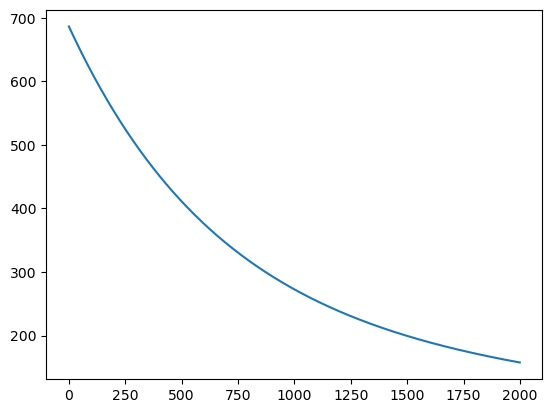

In [61]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
    # 前向传播函数
    def forward(self, x):
        # 计算输入数据 x 与权重矩阵 self.w 的点积，再加上偏置项 self.b
        z = np.dot(x, self.w) + self.b
        return z
    # 损失函数
    def loss(self, z, y):
        # 计算预测值 z 与真实值 y 的误差
        error = z - y
        # 计算误差的平方
        cost = error * error
        # 对误差平方取平均值，得到均方误差
        cost = np.mean(cost)
        # 返回均方误差作为损失值
        return cost
    # 定义梯度计算函数
    def gradient(self, x, y):
        # 前向传播，计算预测值 z
        z = self.forward(x)
        # 计算权重 w 的梯度，公式为：gradient_w = (z - y) * x
        gradient_w = (z-y)*x
        # 对梯度求平均值，axis=0 表示按列求平均
        gradient_w = np.mean(gradient_w, axis=0)
        # 调整梯度形状，确保其为列向量
        gradient_w = gradient_w[:, np.newaxis]
        # 计算偏置 b 的梯度，公式为：gradient_b = (z - y)
        gradient_b = (z - y)
        # 对偏置梯度求平均值
        gradient_b = np.mean(gradient_b)
        # 返回权重和偏置的梯度
        return gradient_w, gradient_b
    # 定义权重更新函数
    def update(self, graident_w5, gradient_w9, eta=0.01):
        net.w[5] = net.w[5] - eta * gradient_w5
        net.w[9] = net.w[9] - eta * gradient_w9
    # 定义训练函数
    def train(self, x, y, iterations=100, eta=0.01):
        points = []
        losses = []
        # 开始迭代训练
        for i in range(iterations):
            
            points.append([net.w[5][0], net.w[9][0]])
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            gradient_w5 = gradient_w[5][0]
            gradient_w9 = gradient_w[9][0]
            self.update(gradient_w5, gradient_w9, eta)
            losses.append(L)
            # 每50次迭代打印一次当前状态
            if i % 50 == 0:
                print('iter {}, point {}, loss {}'.format(i, [net.w[5][0], net.w[9][0]], L))
        # 返回记录的[w5, w9]值和损失值
        return points, losses

# 加载数据集并分离特征和标签
train_data, test_data = load_data()
x = train_data[:, :-1]  # 特征数据
y = train_data[:, -1:]  # 标签数据
# 创建网络
net = Network(13)
# 设置迭代次数
num_iterations=2000
# 启动训练
points, losses = net.train(x, y, iterations=num_iterations, eta=0.01)

# 绘制损失值随迭代次数的变化趋势图
plot_x = np.arange(num_iterations)  # 迭代次数作为x轴
plot_y = np.array(losses)  # 损失值作为y轴
plt.plot(plot_x, plot_y)
plt.show()

In [ ]:
对update和trian函数进行修改，实现其对所有变量的普适，得出最后结果

iter 9, loss 1.898494731457622
iter 19, loss 1.8031783384598723
iter 29, loss 1.7135517565541092
iter 39, loss 1.6292649416831266
iter 49, loss 1.5499895293373234
iter 59, loss 1.4754174896452612
iter 69, loss 1.4052598659324693
iter 79, loss 1.3392455915676866
iter 89, loss 1.2771203802372915
iter 99, loss 1.218645685090292
iter 109, loss 1.1635977224791534
iter 119, loss 1.111766556287068
iter 129, loss 1.0629552390811503
iter 139, loss 1.0169790065644477
iter 149, loss 0.9736645220185994
iter 159, loss 0.9328491676343147
iter 169, loss 0.8943803798194311
iter 179, loss 0.8581150257549611
iter 189, loss 0.8239188186389671
iter 199, loss 0.7916657692169988
iter 209, loss 0.761237671346902
iter 219, loss 0.7325236194855752
iter 229, loss 0.7054195561163928
iter 239, loss 0.6798278472589763
iter 249, loss 0.6556568843183528
iter 259, loss 0.6328207106387195
iter 269, loss 0.6112386712285091
iter 279, loss 0.59083508421862
iter 289, loss 0.5715389327049418
iter 299, loss 0.55328357571003

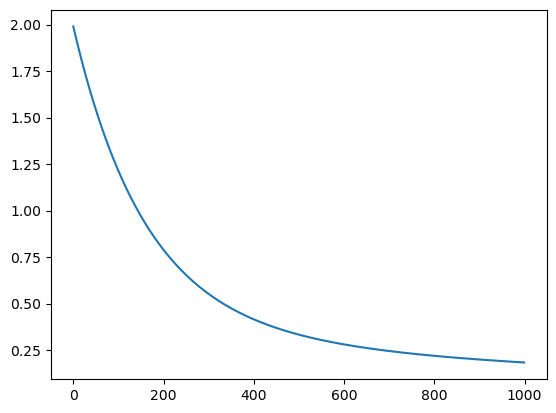

In [63]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
    # 前向传播函数
    def forward(self, x):
        # 计算输入数据 x 与权重矩阵 self.w 的点积，再加上偏置项 self.b
        z = np.dot(x, self.w) + self.b
        return z
    # 损失函数
    def loss(self, z, y):
        # 计算预测值 z 与真实值 y 的误差
        error = z - y
        # 计算误差的平方
        cost = error * error
        # 对误差平方取平均值，得到均方误差
        cost = np.mean(cost)
        # 返回均方误差作为损失值
        return cost
    # 定义梯度计算函数
    def gradient(self, x, y):
        # 前向传播，计算预测值 z
        z = self.forward(x)
        # 计算权重 w 的梯度，公式为：gradient_w = (z - y) * x
        gradient_w = (z-y)*x
        # 对梯度求平均值，axis=0 表示按列求平均
        gradient_w = np.mean(gradient_w, axis=0)
        # 调整梯度形状，确保其为列向量
        gradient_w = gradient_w[:, np.newaxis]
        # 计算偏置 b 的梯度，公式为：gradient_b = (z - y)
        gradient_b = (z - y)
        # 对偏置梯度求平均值
        gradient_b = np.mean(gradient_b)
        # 返回权重和偏置的梯度
        return gradient_w, gradient_b
    # 定义权重更新函数
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
    # 定义训练函数    
    def train(self, x, y, iterations=100, eta=0.01):
        losses = []
        # 开始迭代训练
        for i in range(iterations):
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            self.update(gradient_w, gradient_b, eta)
            losses.append(L)
            # 每10次迭代打印一次当前状态
            if (i+1) % 10 == 0:
                print('iter {}, loss {}'.format(i, L))
        return losses

# 获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network(13)
num_iterations=1000
# 启动训练
losses = net.train(x,y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)  # 迭代次数作为x轴
plot_y = np.array(losses)  # 损失值作为y轴
plt.plot(plot_x, plot_y)
plt.show()